In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision as tv
import torch_utils
from sklearn import svm
from sklearn import metrics
import sklearn.neighbors as knn
from tqdm import tqdm
import utils as ad_utils
import applicability_domain as ad

print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/home/xcha011/venvtorch/lib/python36.zip
/home/xcha011/venvtorch/lib/python3.6
/home/xcha011/venvtorch/lib/python3.6/lib-dynload
/usr/lib/python3.6

/home/xcha011/venvtorch/lib/python3.6/site-packages
/home/xcha011/.local/lib/python3.6/site-packages
/usr/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/xcha011/venvtorch/lib/python3.6/site-packages/IPython/extensions
/home/xcha011/.ipython


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'  # use CPU for testing. GPU doesn't have inf and nan. It could overflow.
print(device)

num_workers = os.cpu_count()
print(num_workers)

cpu
6


In [3]:
DATASET_ROOT = 'dataset_root'
MODEL_PATH = 'mnist_autoencoder_cnn.pt'
L2_FILE_PATH = 'mnist_cw_l2.npy'
LABEL_FILE_PATH = 'mnist_cw_label.npy'
PRED_FILE_PATH = 'mnist_cw_pred.npy'
IMAGE_FILE_PATH = 'mnist_cw_images.npy'
ADV_FILE_PATH = 'mnist_cw_adv.npy'
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_ADV = 200  # aim to generate 1000 adversarial exmaples
NUM_COMPONENTS = 128  # number of components after encoding
C, H, W = 1, 28, 28  # image size in MNIST
IMAGE_DIM = (NUM_ADV, C, H, W)


In [4]:
# prepare data
# the torchvision.transforms.Normalize uses z-score normalization (x - mean) / std. 
# The outpus have 0 mean and 1 std. This scales the images out of [0, 1] range, which we don't want.
transform = tv.transforms.Compose([
        tv.transforms.ToTensor()])
dataset_train = tv.datasets.MNIST(
    DATASET_ROOT,
    train=True, 
    download=True,
    transform=transform)
dataset_test = tv.datasets.MNIST(
    DATASET_ROOT,
    train=False, 
    download=True,
    transform=transform)

loader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)
loader_test = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

In [5]:
# using the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 2),
            nn.ReLU(),
            nn.Upsample((26, 26), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Tanh())
                
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() == (len(x), 1, 28, 28)
        return self.encoder(x)
    
    def decode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() in ((len(x), 128, 1, 1), (len(x), 128))
        
        if x.size() == (len(x), 128):
            x = x.view(len(x), 128, 1, 1)
        
        return self.decoder(x)

In [6]:
autoencoder = Autoencoder()

# extract encoder
for name, module in autoencoder.named_children():
    if name == 'encoder':
        encoder = module

# freeze the encoder. Set gradients to readonly
for p in encoder.parameters():
    p.requires_grad = False

# the neural network without softmax layer
cnn = nn.Sequential(
    encoder,
    nn.Flatten(1),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10))

# the complete neural network for classification
model = nn.Sequential(
    cnn,
    nn.LogSoftmax(dim=1))

In [7]:
# load pretrained parameters
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
model.to(device)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    )
    (1): Flatten()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): LogSoftmax()
)

In [8]:
# load adversarial examples and clean samples
# pytorch uses float32 for inputs
saved_images = np.fromfile(open(IMAGE_FILE_PATH, 'rb'), dtype=np.float32)
saved_images = np.reshape(saved_images, IMAGE_DIM)

saved_advs = np.fromfile(open(ADV_FILE_PATH, 'rb'), dtype=np.float32)
saved_advs = np.reshape(saved_advs, IMAGE_DIM)
assert saved_images.shape == saved_advs.shape

saved_l2 = np.fromfile(open(L2_FILE_PATH, 'rb'), dtype=np.float32)
assert saved_l2.shape == (NUM_ADV,)

# pytorch uses int64 for labels
saved_labels = np.fromfile(open(LABEL_FILE_PATH, 'rb'), dtype=np.int64)
assert saved_labels.shape == (NUM_ADV,)

saved_preds = np.fromfile(open(PRED_FILE_PATH, 'rb'), dtype=np.int64)
assert saved_preds.shape == (NUM_ADV,)

# check saved file
not_equal = np.not_equal(saved_labels, saved_preds)
assert len(not_equal[not_equal==True]) == len(not_equal)


print(saved_images.shape)
print(saved_advs.shape)
print(saved_l2.shape)
print(saved_labels.shape)
print(not_equal.shape)

(200, 1, 28, 28)
(200, 1, 28, 28)
(200,)
(200,)
(200,)


In [9]:
# convert numpy array to pytorch DataLoader
dataset_clean = TensorDataset(
    torch.from_numpy(saved_images), 
    torch.from_numpy(saved_labels))
loader_clean = DataLoader(
    dataset_clean,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

dataset_adv = TensorDataset(
    torch.from_numpy(saved_advs), 
    torch.from_numpy(saved_labels))
loader_adv = DataLoader(
    dataset_adv,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

assert len(loader_clean.dataset) == NUM_ADV
assert len(loader_adv.dataset) == NUM_ADV

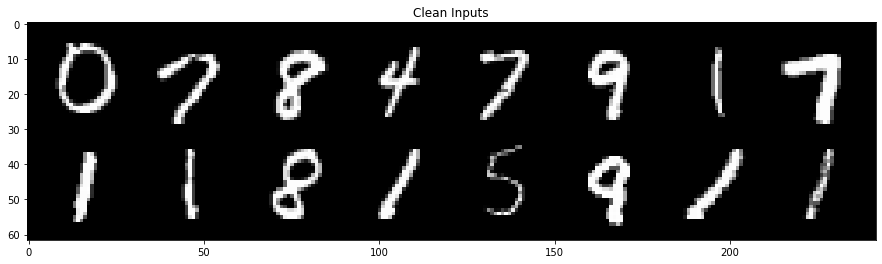

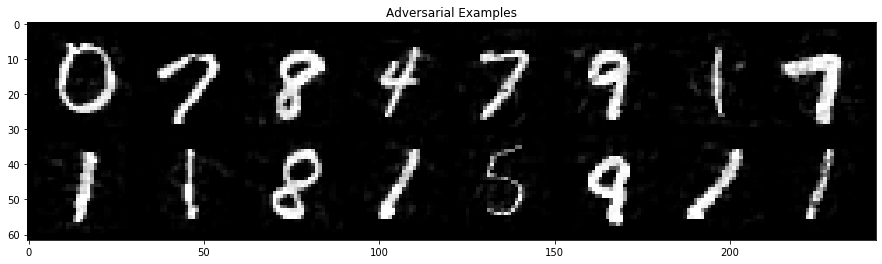

In [10]:
images = torch.from_numpy(saved_images[:16])
plt.figure(figsize=[16, 4])
torch_utils.imshow(images, title='Clean Inputs')
plt.show()

advs = torch.from_numpy(saved_advs[:16])
plt.figure(figsize=[16, 4])
torch_utils.imshow(advs, title='Adversarial Examples')
plt.show()

In [11]:
va_loss, va_acc = torch_utils.validate(model, loader_clean)
print('Clean images - Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

va_loss, va_acc = torch_utils.validate(model, loader_adv)
print('Adversarial examples - Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

print(f'Mean L2 distance: {saved_l2.mean():.4f}')

Clean images - Loss: 0.0104 Accuracy: 100.0000%
Adversarial examples - Loss: 0.7066 Accuracy: 0.0000%
Mean L2 distance: 1.4064


In [12]:
def encode_dataloader(encoder, loader, encoded_outputs):
    assert isinstance(loader, DataLoader), f'{type(loader)}'
    assert isinstance(encoded_outputs, torch.Tensor), f'{type(encoded_outputs)}'

    start = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            batch_size = len(x)
            x_encoded = encoder(x).view(batch_size, -1)
            encoded_outputs[start: start+batch_size] = x_encoded
            start += batch_size
    return encoded_outputs

In [14]:
# start from Stage 2
num_train = len(loader_train.dataset)
num_test = len(loader_test.dataset)
print('num_train', num_train)
print('num_test', num_test)
assert len(loader_adv.dataset) == NUM_ADV   
print('num_adv', NUM_ADV)

since = time.time()
encoded_train = torch.empty(num_train, NUM_COMPONENTS).to(device)
encoded_train = encode_dataloader(autoencoder.encode, loader_train, encoded_train)
time_elapsed = time.time() - since
print('Encoding train set: {:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60))

since = time.time()
encoded_test = torch.empty(num_test, NUM_COMPONENTS).to(device)
encoded_test = encode_dataloader(autoencoder.encode, loader_test, encoded_test)
time_elapsed = time.time() - since
print('Encoding test set: {:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60))

since = time.time()
encoded_ad = torch.empty(NUM_ADV, NUM_COMPONENTS).to(device)
encoded_ad = encode_dataloader(autoencoder.encode, loader_adv, encoded_ad)
time_elapsed = time.time() - since
print('Encoding adversarial example set: {:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60))

since = time.time()
encoded_clean = torch.empty(NUM_ADV, NUM_COMPONENTS).to(device)
encoded_clean = encode_dataloader(autoencoder.encode, loader_clean, encoded_clean)
time_elapsed = time.time() - since
print('Encoding clean subset: {:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60))

num_train 60000
num_test 10000
num_adv 200
Encoding train set: 0m 24.8s
Encoding test set: 0m 4.2s
Encoding adversarial example set: 0m 0.2s
Encoding clean subset: 0m 0.1s


In [15]:
encoded_train_np = encoded_train.cpu().detach().numpy()
encoded_test_np = encoded_test.cpu().detach().numpy()
encoded_ad_np = encoded_ad.cpu().detach().numpy()
encoded_clean_np = encoded_clean.cpu().detach().numpy()
assert encoded_train_np.shape == (num_train, NUM_COMPONENTS)
assert encoded_ad_np.shape == (NUM_ADV, NUM_COMPONENTS)
assert encoded_clean_np.shape == encoded_ad_np.shape

In [16]:
def loader_label_to_np(loader, labels_np):
    assert type(labels_np) == np.ndarray
    assert isinstance(loader, DataLoader)
    assert len(loader.dataset) == len(labels_np)
    
    start = 0
    with torch.no_grad():
        for _, y in loader:
            batch_size = len(y)
            labels_np[start: start+batch_size] = y.detach().numpy()
            start += batch_size
    return labels_np

y_train_np = -np.ones(num_train, dtype=np.int64)
y_train_up = loader_label_to_np(loader_train, y_train_np)

y_test_np = -np.ones(num_test, dtype=np.int64)
y_test_np = loader_label_to_np(loader_test, y_test_np)

In [39]:
# Applicability Domain
K_AD_S2 = 12
ZETA = 0.80

In [17]:
# a list of scikit learn KNN models
knn_models = []

# mu, sd, and are scalar for each labe
k_means = np.empty(NUM_CLASSES, dtype=np.float32)
k_stds = np.empty(NUM_CLASSES, dtype=np.float32)

since = time.time()
with tqdm(total=NUM_CLASSES) as pbar:
    for l in range(NUM_CLASSES):
        indices = np.where(y_train_np == l)
        knn_model = ad_utils.unimodal_knn(encoded_train[indices], K_AD_S2)
        knn_models.append(knn_model)

        # computing mean, standard deviation and threshold
        mu, sd = ad_utils.get_distance_info(
            knn_models[l], encoded_train[indices], K_AD_S2, seen_in_train_set=True)
        k_means[l] = mu
        k_stds[l] = sd
        
        pbar.update(1)
time_elapsed = time.time() - since
print('\nCreating KNN models: {:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Creating KNN models: 0m 16.7s


In [40]:
thresholds = np.empty(NUM_CLASSES, dtype=np.float32)
for i in range(NUM_CLASSES):
    thresholds[i] = ad.get_reliability_threshold(k_means[i], k_stds[i], ZETA)

In [41]:
encoded_passed_s2, indices_passed_s2 = ad.check_reliability(
    encoded_ad_np,
    predictions=saved_preds,
    models=knn_models,
    dist_thresholds=thresholds,
    classes=list(range(NUM_CLASSES)),
    verbose=0)

print(encoded_passed_s2.shape)
print(indices_passed_s2.shape)

(167, 128)
(167,)


In [42]:
# display Stage 2 result
print('\nAfter reliability check:')
print(f'Blocked {NUM_ADV - len(indices_passed_s2)} samples')
pass_rate = ad_utils.get_rate(encoded_passed_s2, saved_advs)
print(f'Pass rate = {pass_rate * 100:.4f}%')
print(f'Mean L2 distance: {saved_l2[indices_passed_s2].mean():.4f}')

conf_mat = metrics.confusion_matrix(saved_labels[indices_passed_s2], saved_preds[indices_passed_s2])
count_mis = len(np.where(np.not_equal(saved_labels[indices_passed_s2], saved_preds[indices_passed_s2]))[0])
print(f'\n# of misclassified = {count_mis}')

print('\nConfusion matrix')
print('Actual classes')
print(' ', *list(range(NUM_CLASSES)), sep='   ')
print(conf_mat)


After reliability check:
Blocked 33 samples
Pass rate = 83.5000%
Mean L2 distance: 1.4183

# of misclassified = 167

Confusion matrix
Actual classes
    0   1   2   3   4   5   6   7   8   9
[[0 0 7 0 0 3 6 0 0 4]
 [0 0 8 0 5 0 0 9 7 0]
 [0 1 0 6 1 0 1 2 6 0]
 [0 0 1 0 0 4 0 0 4 2]
 [1 2 0 0 0 0 2 3 3 2]
 [1 0 0 7 0 0 5 0 4 1]
 [1 0 1 0 5 4 0 0 2 0]
 [0 2 4 6 1 1 0 0 0 3]
 [0 0 6 4 0 1 1 1 0 2]
 [0 0 0 4 6 0 0 0 4 0]]


In [43]:
encoded_test_left, indices_test_left = ad.check_reliability(
    encoded_clean_np,
    predictions=saved_labels,
    models=knn_models,
    dist_thresholds=thresholds,
    classes=list(range(NUM_CLASSES)),
    verbose=0)

print(encoded_test_left.shape)
print(indices_test_left.shape)
pass_rate = ad_utils.get_rate(indices_test_left, saved_labels)
print(f'Pass rate = {pass_rate * 100:.4f}%')

(169, 128)
(169,)
Pass rate = 84.5000%


In [44]:
# Stage 3 - Decidability
# parameters for Decidability Stage
K_AD_S3 = 12

adv_s2 = saved_advs[indices_passed_s2]
y_s2 = saved_labels[indices_passed_s2]
pred_s2 = saved_preds[indices_passed_s2]
encoded_s2 = encoded_ad_np[indices_passed_s2]

# shuffle_indices = np.random.permutation(num_train)
# shuffle10 = shuffle_indices[:num_train//10]

print('\n---------- Decidability ----------------')
print(f'Parameters: k = {K_AD_S3}')


---------- Decidability ----------------
Parameters: k = 12


In [52]:
# the knnn model with complete train set
comp_knn_model = knn.KNeighborsClassifier(
    n_neighbors=K_AD_S3,
    n_jobs=-1,
    weights='distance'
)
# comp_knn_model.fit(encoded_train_np[shuffle10], y_train_np[shuffle10])
comp_knn_model.fit(encoded_train_np, y_train_np)
print(comp_knn_model.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [53]:
# TODO: accuracy on test set does NOT look correct!

# test performance on train set
since = time.time()
pred_train = comp_knn_model.predict(encoded_train_np)
score = metrics.accuracy_score(y_train_np, pred_train)
time_elapsed = time.time() - since
print('Time taken: {:.0f}m {:.1f}s - Accuracy on train set: {:.4f}%'.format(
    time_elapsed // 60, 
    time_elapsed % 60, 
    score * 100))

# test performance on test set
since = time.time()
pred_test = comp_knn_model.predict(encoded_test_np)
score = metrics.accuracy_score(y_test_np, pred_test)
time_elapsed = time.time() - since
print('Time taken: {:.0f}m {:.1f}s - Accuracy on test set: {:.4f}%'.format(
    time_elapsed // 60, 
    time_elapsed % 60, 
    score * 100))

# test performance on clean set
pred_clean = comp_knn_model.predict(encoded_clean_np)
score = metrics.accuracy_score(saved_labels, pred_clean)
print(f'Accuracy on clean test set  = {score*100:.4f}%')

Time taken: 2m 32.8s - Accuracy on train set: 100.0000%
Time taken: 0m 25.7s - Accuracy on test set: 10.5600%
Accuracy on clean test set  = 11.0000%


In [ ]:
pred_adv = comp_knn_model.predict(encoded_ad_np)
score = metrics.accuracy_score(saved_labels, pred_adv)
print(f'Accuracy on adversarial examples = {score*100:.4f}%')
print('Accuracy on CNN model is 0.0%')

In [ ]:
encoded_passed_s3, indices_passed_s3 = ad.check_decidability(
    encoded_s2,
    pred_s2,
    comp_knn_model
)
indices_passed_s3 = indices_passed_s3[0]

print(encoded_passed_s3.shape)
print(indices_passed_s3.shape)

In [ ]:
# Stage 3 result
ad_s3 = adv_s2[indices_passed_s3]
y_s3 = y_s2[indices_passed_s3]
pred_s3 = pred_s2[indices_passed_s3]

print(f'Blocked {len(indices_passed_s2) - len(indices_passed_s3)} samples')

pass_rate = ad_utils.get_rate(indices_passed_s3, indices_passed_s2)
print(f'Pass rate on 3rd stage = {pass_rate * 100:.4f}%')
pass_rate = ad_utils.get_rate(encoded_passed_s3, saved_advs)
print(f'Pass rate overall = {pass_rate * 100:.4f}%')

print(f'\n# of samples after AD = {len(indices_passed_s3)}')
print(f'Total blocked samples = {NUM_ADV - len(indices_passed_s3)}')

In [ ]:

conf_mat = metrics.confusion_matrix(y_s3, pred_s3)
indices_mis = np.where(np.not_equal(y_s3, pred_s3))[0]
count_mis = len(indices_mis)
print(f'# of misclassified = {count_mis}')

print('\nConfusion matrix')
print('Actual classes')
print(' ', *list(range(10)), sep='   ')
print(conf_mat)

In [ ]:
print(saved_labels[:32])
print(saved_preds[:32])